In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
import gensim.downloader as api

import matplotlib.pyplot as plt


In [29]:
df = pd.read_csv(r"C:\adnan_venv_310\archive\Consumer Review of Clothing Product\data_amazon.xlsx - Sheet1.csv")

TEXT = "Review"
LABELS = ["Materials", "Construction", "Color", "Finishing", "Durability"]

df = df.dropna(subset=[TEXT])

X = df[TEXT].astype(str).tolist()
Y = (df[LABELS].fillna(0) > 0).astype(int).values

print(df.shape)


(48507, 9)


In [23]:
def tokenize(text):
    return simple_preprocess(text)

tokens = [tokenize(doc) for doc in X]


In [ ]:
w2v_model = Word2Vec( #word2vec embeddings
    sentences=tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)

vocab = set(w2v_model.wv.index_to_key)

def word2vec_embedding(doc):
    vectors = [w2v_model.wv[word] for word in doc if word in vocab]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_w2v = np.array([word2vec_embedding(doc) for doc in tokens])
print(X_w2v.shape)


(48507, 100)


In [26]:
glove = api.load("glove-wiki-gigaword-100")
dim = glove.vector_size

def glove_embedding(doc):
    vectors = [glove[word] for word in doc if word in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

X_glove = np.array([glove_embedding(doc) for doc in tokens])
print(X_glove.shape)


(48507, 100)


In [30]:
from sklearn.multioutput import MultiOutputClassifier

def evaluate_model(X, Y, name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    base = LogisticRegression(max_iter=2000)
    model = MultiOutputClassifier(base)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} – Classification Report\n")
    print(classification_report(
        y_test,
        y_pred,
        target_names=LABELS,
        zero_division=0
    ))

    micro = f1_score(y_test, y_pred, average="micro", zero_division=0)
    macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

    return {
        "Model": name,
        "Micro F1": micro,
        "Macro F1": macro
    }


In [31]:
#run experiments
results = []

results.append(evaluate_model(X_w2v, Y, "Word2Vec"))
results.append(evaluate_model(X_glove, Y, "GloVe"))




Word2Vec – Classification Report

              precision    recall  f1-score   support

   Materials       0.24      0.01      0.03       337
Construction       0.43      0.01      0.01       581
       Color       0.22      0.03      0.06       290
   Finishing       0.06      0.00      0.01       299
  Durability       0.53      0.09      0.16       260

   micro avg       0.32      0.02      0.05      1767
   macro avg       0.30      0.03      0.05      1767
weighted avg       0.31      0.02      0.04      1767
 samples avg       0.00      0.00      0.00      1767


GloVe – Classification Report

              precision    recall  f1-score   support

   Materials       0.22      0.01      0.01       337
Construction       0.00      0.00      0.00       581
       Color       0.26      0.03      0.06       290
   Finishing       0.07      0.00      0.01       299
  Durability       0.50      0.09      0.16       260

   micro avg       0.31      0.02      0.04      1767
   macro a

In [32]:
#results TAble
results_df = pd.DataFrame(results)
results_df


,Model,Micro F1,Macro F1
0,Word2Vec,0.045192,0.052273
1,GloVe,0.038237,0.045832


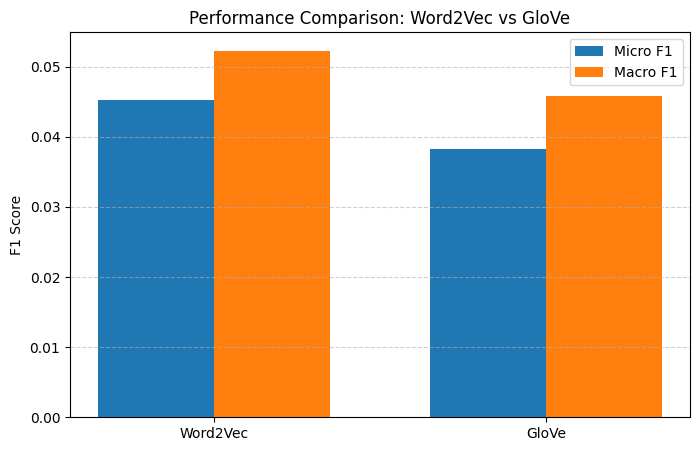

In [33]:
#comparison plot
models = results_df["Model"].tolist()
micro_scores = results_df["Micro F1"].tolist()
macro_scores = results_df["Macro F1"].tolist()

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, micro_scores, width, label="Micro F1")
plt.bar(x + width/2, macro_scores, width, label="Macro F1")

plt.xticks(x, models)
plt.ylabel("F1 Score")
plt.title("Performance Comparison: Word2Vec vs GloVe")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()
